In [2]:
# Import necessary packages

from fairness_metrics import fair_metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, r2_score, mutual_info_score

import numpy as np
from scipy import stats, spatial
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

Choose which attributes you would like to keep for the analysis. The feature description in the exercise file contains a list of key attributes).

In [7]:
import pandas as pd

# Load the dataset from the raw GitHub link
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
data = pd.read_csv(url)

# Check the column names to ensure they are read correctly
print("Columns in the dataset:")
print(data.columns)

# Define the relevant columns to keep
relevant_columns = [
    "id", "age", "race", "sex", "priors_count", 
    "c_charge_degree", "is_recid", "two_year_recid"
]

# Filter the dataset to keep only the relevant columns
filtered_data = data[relevant_columns]

# Display the first few rows of the filtered dataset
print("\nFiltered Data:")
filtered_data.head()

# Save the dataset as a CSV file in the current folder
csv_file = "recidivism.csv"
data.to_csv(csv_file, index=False)

print(f"\nDataset saved as '{csv_file}' in the current folder.")

Columns in the dataset:
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

Filtered Data:

Dataset 

In [9]:
# Drop the features you are not interested in

#X = pd.read_csv("recidivism.csv")
X = filtered_data
X = X.drop(["id", "is_recid", "two_year_recid"], axis=1)

X

,age,race,sex,priors_count,c_charge_degree
0,69,Other,Male,0,F
1,34,African-American,Male,0,F
2,24,African-American,Male,4,F
3,23,African-American,Male,1,F
4,43,Other,Male,2,F
...,...,...,...,...,...
7209,23,African-American,Male,0,F
7210,23,African-American,Male,0,F
7211,57,Other,Male,0,F
7212,33,African-American,Female,3,M


## Feature Engineering

In [12]:
y = filtered_data["two_year_recid"]

In [14]:
# Modify as needed
#X = data.drop("", axis=1)

In [16]:
X = pd.get_dummies(X, drop_first=True)

In [18]:
X

,age,priors_count,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male,c_charge_degree_M
0,69,0,False,False,False,False,True,True,False
1,34,0,False,False,False,False,False,True,False
2,24,4,False,False,False,False,False,True,False
3,23,1,False,False,False,False,False,True,False
4,43,2,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...
7209,23,0,False,False,False,False,False,True,False
7210,23,0,False,False,False,False,False,True,False
7211,57,0,False,False,False,False,True,True,False
7212,33,3,False,False,False,False,False,False,True


## Create a Model

In [21]:
#!pip install xgboost

In [23]:
import xgboost as xgb

In [25]:
model = LogisticRegression()

In [27]:
# Let's split into 30% for training
# Stratify by y to maintain same class distribution. Remaining data is saved in _temp files.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then 30% for validation from the remaining 70%. The last portion will be saved for test
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display the size of each set
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_validate.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (5049, 9)
Validation set size: (1082, 9)
Test set size: (1083, 9)


In [29]:
# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Step 3: Train a model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_prob = model.predict_proba(X_validate)[:, 1]  # Predicted probabilities
y_pred = model.predict(X_validate)  # Predicted binary outcomes


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:39:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

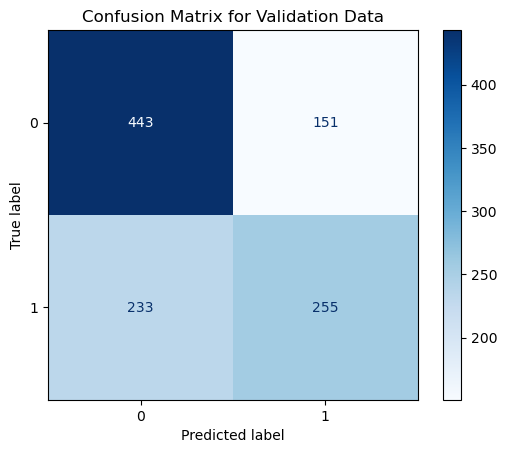

In [33]:
# Display the confusion matrix
cm = confusion_matrix(y_validate, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Data")
plt.show()

In [35]:
# Predict probabilities and binary outcomes on the validation set
y_pred_prob = model.predict_proba(X_validate)[:, 1]
y_pred_binary = model.predict(X_validate)

### Calculate Fairness Metrics

In [38]:
X_validate

,age,priors_count,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male,c_charge_degree_M
685,32,2,False,False,False,False,False,False,False
7158,21,1,False,False,False,False,False,True,False
4497,23,1,False,False,False,False,False,False,True
4916,30,8,False,False,False,False,False,False,False
3541,31,2,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...
4915,26,3,False,False,False,False,False,True,True
2974,41,8,False,False,False,False,False,True,False
393,27,12,False,False,False,False,False,True,False
1262,45,5,False,True,False,False,False,False,True


In [41]:
X_validate['sex'] = filtered_data.loc[X_validate.index, 'sex']
protected_group_name = "sex"
adv_val = 'Male'  # Male as advantaged
disadv_val = 'Female'  # Female as disadvantaged
y_validate_numeric = y_validate

In [43]:
fairness_metrics = fair_metrics(
    y_validate_numeric,
    y_pred_prob,
    y_pred_binary,
    X_validate,
    protected_group_name,
    adv_val,
    disadv_val
)

# Let's read the output cleanly.
for metric_name, metric_value in fairness_metrics:
    print(f"{metric_name}:{metric_value:.4f}")

AUC:0.0144
Avg PrecScore:0.0595
Equal Opps:0.2099
PredEq:0.1440
Equal Odds:0.3540
PredParity:0.0606
DemoParity:0.1984
AOD:0.1770
TEq:1.1607


In [45]:
filtered_data['race'].value_counts()


race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64

In [47]:
# Ensure the 'race' column is aligned with the indices in X_validate
X_validate['race'] = filtered_data.loc[X_validate.index, 'race']

# Define the advantaged group (e.g., 'White')
adv_val = 'Caucasian'  # You can change this as needed

# List of all unique races in the dataset
unique_races = ['African-American', 'Hispanic', 'Other', 'Asian', 'Native American']

# Loop through each race category (except the advantaged one)
for disadv_val in unique_races:
    if disadv_val != adv_val:  # Skip comparison if it's the advantaged group itself
        print(f"\nFairness metrics comparing {adv_val} vs. {disadv_val}:")
        
        # Calculate fairness metrics for the race attribute
        fairness_metrics = fair_metrics(
            y_validate_numeric,
            y_pred_prob,  # Probabilities predicted by the model
            y_pred_binary,  # Binary predictions from the model
            X_validate,  # Validation data with the race column added
            'race',  # Name of the protected group (race)
            adv_val,  # Advantaged group (e.g., 'White')
            disadv_val  # Disadvantaged group (current iteration)
        )

        # Display the fairness metrics
        for metric_name, metric_value in fairness_metrics:
            print(f"{metric_name}: {metric_value:.4f}")



Fairness metrics comparing Caucasian vs. African-American:
AUC: 0.0890
Avg PrecScore: 0.2220
Equal Opps: 0.3437
PredEq: 0.1456
Equal Odds: 0.4893
PredParity: 0.1702
DemoParity: 0.2617
AOD: 0.2447
TEq: 1.0698

Fairness metrics comparing Caucasian vs. Hispanic:
AUC: 0.0113
Avg PrecScore: 0.0093
Equal Opps: 0.0603
PredEq: 0.0278
Equal Odds: 0.0326
PredParity: 0.1213
DemoParity: 0.0139
AOD: 0.0163
TEq: 0.5302

Fairness metrics comparing Caucasian vs. Other:
AUC: 0.1858
Avg PrecScore: 0.2664
Equal Opps: 0.0406
PredEq: 0.1401
Equal Odds: 0.1807
PredParity: 0.2837
DemoParity: 0.0936
AOD: 0.0904
TEq: 6.9302

Fairness metrics comparing Caucasian vs. Asian:
AUC: 0.3790
Avg PrecScore: 0.5137
Equal Opps: 0.3206
PredEq: 0.1972
Equal Odds: 0.5179
PredParity: nan
DemoParity: 0.2436
AOD: 0.2589
TEq: inf

Fairness metrics comparing Caucasian vs. Native American:
AUC: 0.3790
Avg PrecScore: 0.5137
Equal Opps: 0.3206
PredEq: 0.1972
Equal Odds: 0.5179
PredParity: nan
DemoParity: 0.2436
AOD: 0.2589
TEq: in

/Users/preethip/Documents/Exam/fairness_metrics.py:89: RuntimeWarning: invalid value encountered in scalar divide
  prec_disadv = tp_disadv / (tp_disadv + fp_disadv)
/Users/preethip/Documents/Exam/fairness_metrics.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  TE_disadv = fn_disadv / fp_disadv
/Users/preethip/Documents/Exam/fairness_metrics.py:89: RuntimeWarning: invalid value encountered in scalar divide
  prec_disadv = tp_disadv / (tp_disadv + fp_disadv)
/Users/preethip/Documents/Exam/fairness_metrics.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  TE_disadv = fn_disadv / fp_disadv


## Check for Proxy Features

In [55]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [149]:
data.columns


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [273]:
# for proxies
filtered_columns = [
    'sex','race','priors_count', 'juv_fel_count', 'juv_misd_count', 'c_charge_degree', 'v_type_of_assessment',
    'c_charge_desc', 'priors_count'
]

# Subset your data
X = data[filtered_columns]

In [275]:
X 

,sex,race,priors_count,juv_fel_count,juv_misd_count,c_charge_degree,v_type_of_assessment,c_charge_desc,priors_count
0,Male,Other,0,0,0,F,Risk of Violence,Aggravated Assault w/Firearm,0
1,Male,African-American,0,0,0,F,Risk of Violence,Felony Battery w/Prior Convict,0
2,Male,African-American,4,0,0,F,Risk of Violence,Possession of Cocaine,4
3,Male,African-American,1,0,1,F,Risk of Violence,Possession of Cannabis,1
4,Male,Other,2,0,0,F,Risk of Violence,arrest case no charge,2
...,...,...,...,...,...,...,...,...,...
7209,Male,African-American,0,0,0,F,Risk of Violence,Deliver Cannabis,0
7210,Male,African-American,0,0,0,F,Risk of Violence,Leaving the Scene of Accident,0
7211,Male,Other,0,0,0,F,Risk of Violence,Aggravated Battery / Pregnant,0
7212,Female,African-American,3,0,0,M,Risk of Violence,Battery on Law Enforc Officer,3


In [279]:
X['race_encoded'] = LabelEncoder().fit_transform(X['race'])

/var/folders/9k/26jq4s4s4213tzr7kdtsr4zc0000gn/T/ipykernel_14333/1445739694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['race_encoded'] = LabelEncoder().fit_transform(X['race'])


In [281]:
# Calculate mean target value for each category
charge_mean = data.groupby('c_charge_desc')['two_year_recid'].mean()
X['c_charge_desc_encoded'] = X['c_charge_desc'].map(charge_mean)

/var/folders/9k/26jq4s4s4213tzr7kdtsr4zc0000gn/T/ipykernel_14333/4248742884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_desc_encoded'] = X['c_charge_desc'].map(charge_mean)


In [283]:
X = pd.get_dummies(X, columns=['sex','c_charge_degree', 'v_type_of_assessment'], drop_first=True)

In [285]:
X

,race,priors_count,juv_fel_count,juv_misd_count,c_charge_desc,priors_count,race_encoded,c_charge_desc_encoded,sex_Male,c_charge_degree_M
0,Other,0,0,0,Aggravated Assault w/Firearm,0,5,0.291667,True,False
1,African-American,0,0,0,Felony Battery w/Prior Convict,0,0,0.565217,True,False
2,African-American,4,0,0,Possession of Cocaine,4,0,0.592827,True,False
3,African-American,1,0,1,Possession of Cannabis,1,0,0.368421,True,False
4,Other,2,0,0,arrest case no charge,2,5,0.446790,True,False
...,...,...,...,...,...,...,...,...,...,...
7209,African-American,0,0,0,Deliver Cannabis,0,0,0.470588,True,False
7210,African-American,0,0,0,Leaving the Scene of Accident,0,0,0.461538,True,False
7211,Other,0,0,0,Aggravated Battery / Pregnant,0,5,0.566038,True,False
7212,African-American,3,0,0,Battery on Law Enforc Officer,3,0,0.535714,False,True


In [301]:
gender_proxies = [ 'priors_count', 'juv_fel_count', 'juv_misd_count', 'c_charge_degree_M']
race_proxies = ['c_charge_desc_encoded', 'c_charge_degree_M', 'priors_count']

In [303]:
# Define function to test correlation between features and a protected attribute
def test_proxy_correlation(feature, target='age'):
    print(f"Testing correlation between {feature} and {target}...\n")
    
    # Prepare X and y
    X_feat = X[[feature]].astype(int)
    y_target = X[target].astype(int)   # Directly use the target column from `X`
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_feat, y_target)

    # Use statsmodels for detailed regression output
    X_const = sm.add_constant(X_feat)  # Add constant for intercept
    model_sm = sm.OLS(y_target, X_const).fit()

    # Print regression summary
    print(model_sm.summary())
    print("\n" + "="*80 + "\n")

In [305]:
X.head()

,race,priors_count,juv_fel_count,juv_misd_count,c_charge_desc,priors_count,race_encoded,c_charge_desc_encoded,sex_Male,c_charge_degree_M
0,Other,0,0,0,Aggravated Assault w/Firearm,0,5,0.291667,True,False
1,African-American,0,0,0,Felony Battery w/Prior Convict,0,0,0.565217,True,False
2,African-American,4,0,0,Possession of Cocaine,4,0,0.592827,True,False
3,African-American,1,0,1,Possession of Cannabis,1,0,0.368421,True,False
4,Other,2,0,0,arrest case no charge,2,5,0.446790,True,False


In [307]:
X = X.dropna()

In [319]:
gender_proxies = [ 'priors_count', 'c_charge_degree_M']
race_proxies = ['c_charge_degree_M', 'priors_count']

In [321]:
for i in gender_proxies:
    test_proxy_correlation(i, target='sex_Male')


Testing correlation between priors_count and sex_Male...

                            OLS Regression Results                            
Dep. Variable:               sex_Male   R-squared:                      -0.006
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    -20.33
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               1.00
Time:                        14:33:07   Log-Likelihood:                -3535.8
No. Observations:                7185   AIC:                             7078.
Df Residuals:                    7182   BIC:                             7098.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [317]:

for j in race_proxies:
    test_proxy_correlation(j, target='race_encoded')

Testing correlation between c_charge_degree_M and race_encoded...

                            OLS Regression Results                            
Dep. Variable:           race_encoded   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     40.03
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           2.65e-10
Time:                        14:32:37   Log-Likelihood:                -12692.
No. Observations:                7185   AIC:                         2.539e+04
Df Residuals:                    7183   BIC:                         2.540e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [73]:
# Select only numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
print("Numeric columns:", numeric_columns)

Numeric columns: Index(['id', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_days_from_compas', 'is_recid', 'r_days_from_arrest', 'violent_recid',
       'is_violent_recid', 'decile_score.1', 'v_decile_score',
       'priors_count.1', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


In [77]:
# Not all approaches work with all datatypes. Separate the continuous features.
#Gender proxies
continuous_features = ['juv_fel_count', 'juv_misd_count', 'priors_count', 'decile_score', 'days_b_screening_arrest']
X_continuous = data[continuous_features]

In [85]:
X_const = sm.add_constant(X_continuous)
X_const = X_const.dropna()

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [89]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

print(vif_data)

                   feature       VIF
0                    const  3.545388
1            juv_fel_count  1.048059
2           juv_misd_count  1.082600
3             priors_count  1.293492
4             decile_score  1.277082
5  days_b_screening_arrest  1.002454


In [103]:
#gender proxies
continuous_features = ['priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'v_decile_score', 'is_violent_recid', 'two_year_recid']
X_continuous = data[continuous_features]

In [105]:
X_const = sm.add_constant(X_continuous)
X_const = X_const.dropna()

In [107]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

print(vif_data)

            feature       VIF
0             const  3.586106
1      priors_count  1.172767
2     juv_fel_count  1.054974
3    juv_misd_count  1.158330
4   juv_other_count  1.108727
5    v_decile_score  1.194023
6  is_violent_recid  1.156581
7    two_year_recid  1.289366


## Check for Bias in Data

You may want to reload your dataset specially if you run into any type of error.

In [ ]:
# Calculate bias metrics. Need -> data_frame, protected_group, Sa_label, Sd_label, Y, fav_label


In [270]:
filtered_data

,id,age,race,sex,priors_count,c_charge_degree,is_recid,two_year_recid
0,1,69,Other,Male,0,F,0,0
1,3,34,African-American,Male,0,F,1,1
2,4,24,African-American,Male,4,F,1,1
3,5,23,African-American,Male,1,F,0,0
4,6,43,Other,Male,2,F,0,0
...,...,...,...,...,...,...,...,...
7209,10996,23,African-American,Male,0,F,0,0
7210,10997,23,African-American,Male,0,F,0,0
7211,10999,57,Other,Male,0,F,0,0
7212,11000,33,African-American,Female,3,M,0,0


In [137]:
# Recreate the visualization. See reference below.
def statistical_parity_test(data, protected_group, Sa_label, Sd_label, Y, fav_label):
    Sa = data[data[protected_group] == Sa_label]
    Fav_Sa = Sa[Sa[Y] == fav_label]
    Fav_Sa_count = len(Fav_Sa)
    Advantageous = len(Sa)
    
    Sd = data[data[protected_group] == Sd_label]
    Fav_Sd = Sd[Sd[Y] == fav_label]
    Fav_Sd_count = len(Fav_Sd)
    dis_Advantageous = len(Sd)
    
    statistical_parity = (Fav_Sd_count / dis_Advantageous) - (Fav_Sa_count / Advantageous)
    disparate_impact = (Fav_Sd_count / dis_Advantageous) / (Fav_Sa_count / Advantageous)
    
    print(Sd_label)
    print(f"\nStatistical Parity Difference: {statistical_parity}")
    print(f"Disparate Impact: {disparate_impact}")

    # Visualization
    categories = [protected_group]
    stat_parity_diff = [statistical_parity]
    disparate_impact_vals = [disparate_impact]

    bar_width = 0.35
    x = np.arange(len(categories))

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.bar(x - bar_width / 2, stat_parity_diff, bar_width, color='red', label='Stat Parity Diff')
    ax2 = ax1.twinx()
    ax2.bar(x + bar_width / 2, disparate_impact_vals, bar_width, color='black', label='Disparate Impact')

    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha='right')

    ax1.set_xlabel('Protected Feature')
    ax1.set_ylabel('Statistical Parity Difference', color='red')
    ax2.set_ylabel('Disparate Impact', color='black')
    plt.title(f'Statistical Parity Difference and Disparate Impact for {Sd_label}')

    ax1.axhline(y=0.1, color='red', linestyle='--', linewidth=1)
    ax2.axhline(y=0.8, color='black', linestyle='--', linewidth=1)
    ax2.axhline(y=1.2, color='black', linestyle='--', linewidth=1)

    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    fig.tight_layout()
    plt.show()

    return statistical_parity, disparate_impact

In [141]:
race = ['African-American', 'Hispanic', 'Other', 'Asian', 'Native American']
values = []

African-American

Statistical Parity Difference: -0.12069679505498576
Disparate Impact: 0.8009476242843179


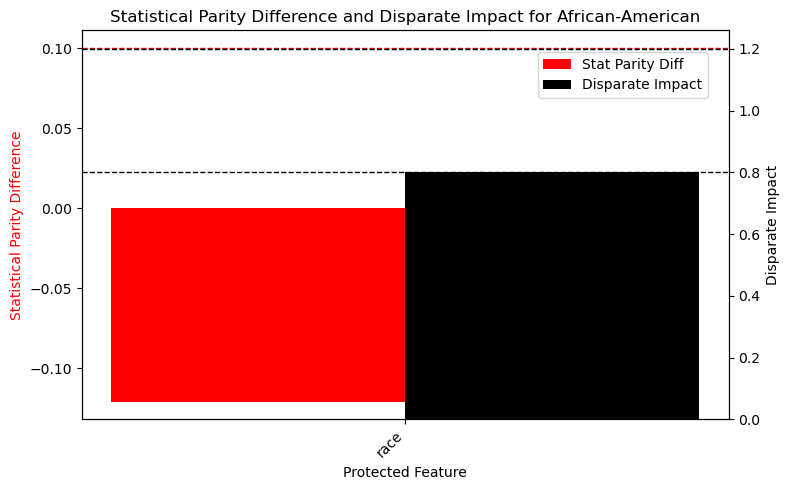

Hispanic

Statistical Parity Difference: 0.02943581043476251
Disparate Impact: 1.0485453486605558


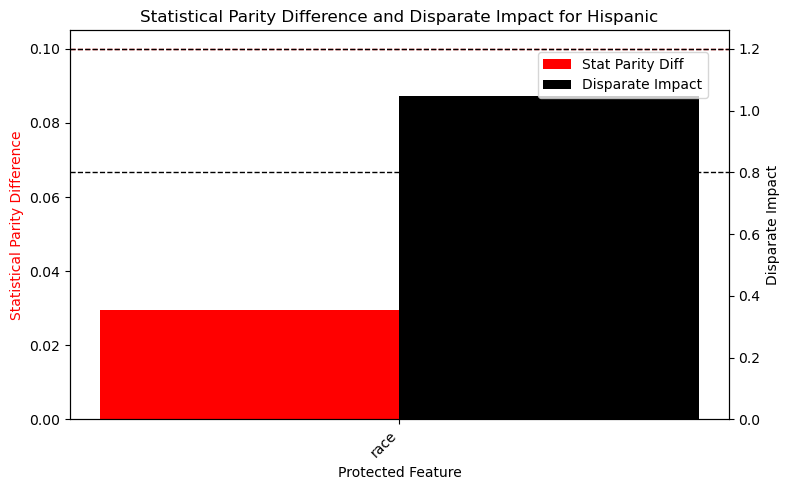

Other

Statistical Parity Difference: 0.04085788589624695
Disparate Impact: 1.0673825618208266


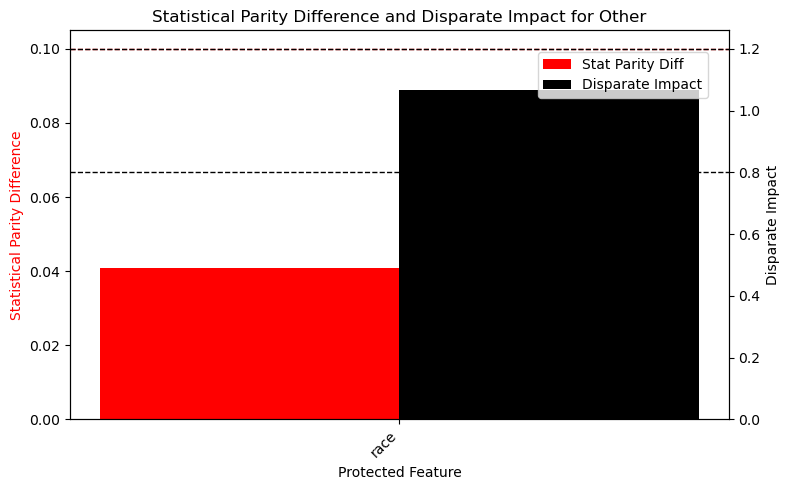

Asian

Statistical Parity Difference: 0.11239303178484106
Disparate Impact: 1.1853578629032258


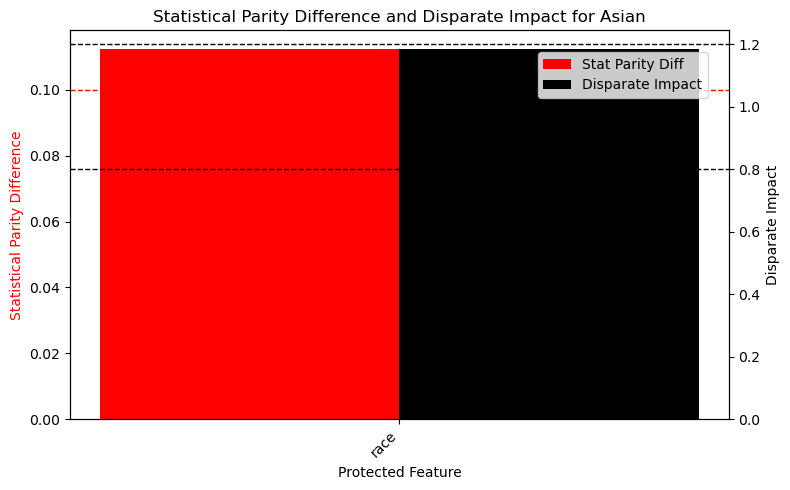

Native American

Statistical Parity Difference: -0.16191252377071452
Disparate Impact: 0.7329749103942652


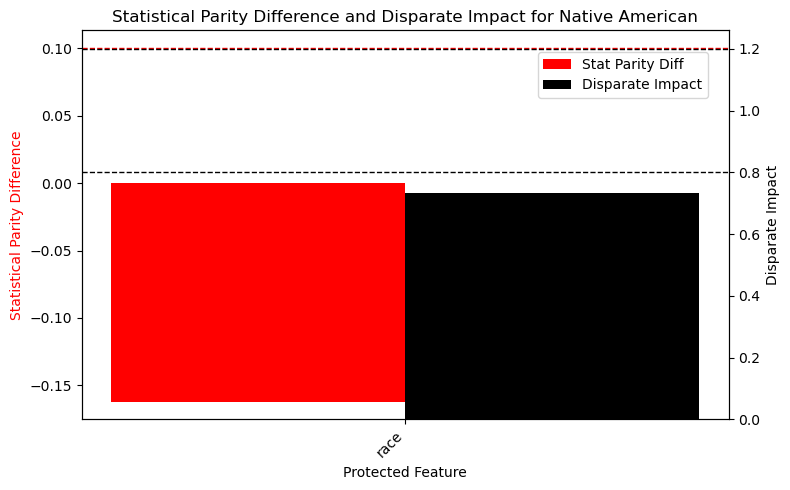

In [143]:
for r in race:
    values.append(statistical_parity_test(
    filtered_data, 
    protected_group='race', 
    Sa_label='Caucasian', 
    Sd_label= r, 
    Y='two_year_recid', 
    fav_label=0
))

In [131]:
values

[(-0.12069679505498576, 0.8009476242843179),
 (0.02943581043476251, 1.0485453486605558),
 (0.04085788589624695, 1.0673825618208266),
 (0.11239303178484106, 1.1853578629032258),
 (-0.16191252377071452, 0.7329749103942652)]

In [133]:
stat_parity_diff = [item[0] for item in values]
disparate_impact = [item[1] for item in values]

#### Reference code for visualization

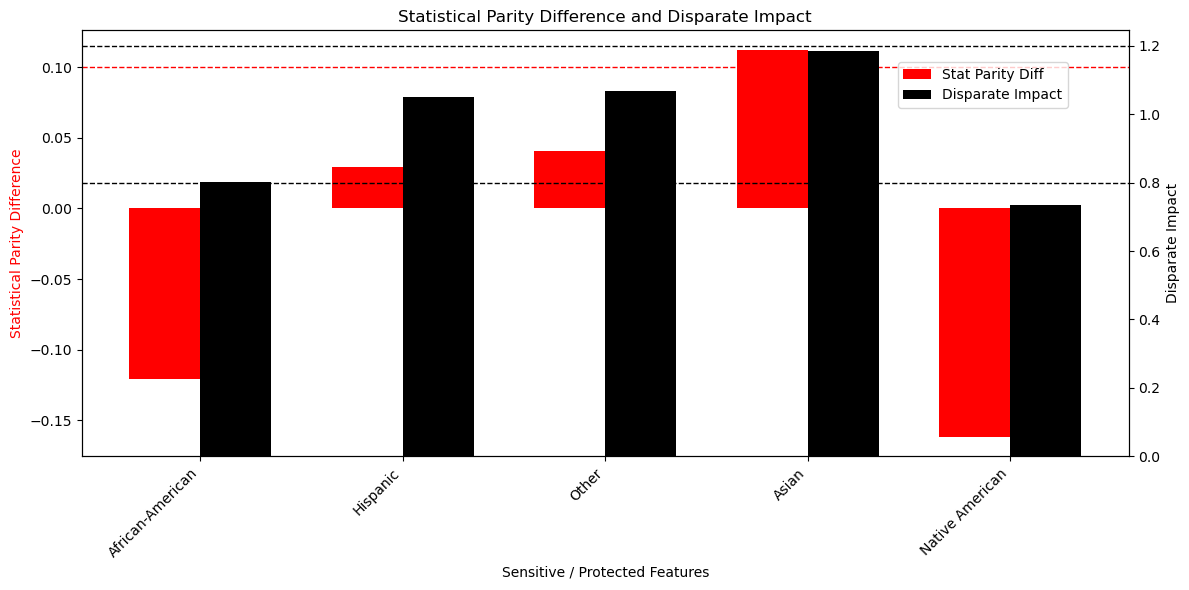

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Example Data (Replace with your own data)
categories = ['African-American', 'Hispanic', 'Other', 'Asian', 'Native American']
#stat_parity_diff = [0.05, 0.10, 0.15, 0.12, 0.18, 0.08, 0.10, 0.15, 0.09, 0.14, 0.10, 0.11, 0.16, 0.07, 0.08]  # Example statistical parity diff
#disparate_impact = [1.1, 1.2, 1.25, 1.15, 1.3, 1.1, 1.05, 1.2, 1.1, 1.3, 1.25, 1.15, 1.35, 1.2, 1.25]  # Example disparate impact

# Bar Width and Positioning
bar_width = 0.35  # Width of each bar
x = np.arange(len(categories))  # X-axis positions for bars

# Create the Figure and Axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Statistical Parity Difference (Red Bars)
ax1.bar(x - bar_width/2, stat_parity_diff, bar_width, color='red', label='Stat Parity Diff')

# Create a second Y-axis for Disparate Impact
ax2 = ax1.twinx()

# Plot Disparate Impact (Black Bars)
ax2.bar(x + bar_width/2, disparate_impact, bar_width, color='black', label='Disparate Impact')

# Set X-axis Labels
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right')

# Add Titles and Labels
ax1.set_xlabel('Sensitive / Protected Features')
ax1.set_ylabel('Statistical Parity Difference', color='red')
ax2.set_ylabel('Disparate Impact', color='black')
plt.title('Statistical Parity Difference and Disparate Impact')

# Add Threshold Lines
ax1.axhline(y=0.1, color='red', linestyle='--', linewidth=1)
ax2.axhline(y=0.8, color='black', linestyle='--', linewidth=1)
ax2.axhline(y=1.2, color='black', linestyle='--', linewidth=1)

# Add Legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

# Adjust Layout
fig.tight_layout()

# Show Plot
plt.show()

In [281]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def statistical_parity_test(data, protected_group, Sa_label, Sd_label, Y, fav_label):
    """
    Statistical Parity difference and Disparate Impact with visualization.
    
    Parameters
    -----------
    :param data: DataFrame containing the data
    :param protected_group: Column name of protected feature
    :param Sa_label: Label for the advantageous group
    :param Sd_label: Label for the disadvantageous group
    :param Y: Name of the target variable
    :param fav_label: Label for favorable outcome
    
    Returns
    --------
    Visualization of Statistical Parity Difference and Disparate Impact.
    """
    # Calculate metrics for the advantageous group
    Sa = data[data[protected_group] == Sa_label]
    Fav_Sa = Sa[Sa[Y] == fav_label]
    Fav_Sa_count = len(Fav_Sa)
    Advantageous = len(Sa)
    
    # Calculate metrics for the disadvantageous group
    Sd = data[data[protected_group] == Sd_label]
    Fav_Sd = Sd[Sd[Y] == fav_label]
    Fav_Sd_count = len(Fav_Sd)
    dis_Advantageous = len(Sd)
    
    # Calculate Statistical Parity Difference and Disparate Impact
    statistical_parity = (Fav_Sd_count / dis_Advantageous) - (Fav_Sa_count / Advantageous)
    disparate_impact = (Fav_Sd_count / dis_Advantageous) / (Fav_Sa_count / Advantageous)

    # Print metrics
    print(f"Statistical Parity Difference: {statistical_parity}")
    print(f"Disparate Impact: {disparate_impact}")

    # Visualization
    categories = [protected_group]
    stat_parity_diff = [statistical_parity]
    disparate_impact_vals = [disparate_impact]

    bar_width = 0.35
    x = np.arange(len(categories))

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot Statistical Parity Difference
    ax1.bar(x - bar_width / 2, stat_parity_diff, bar_width, color='red', label='Stat Parity Diff')

    # Create a second Y-axis for Disparate Impact
    ax2 = ax1.twinx()
    ax2.bar(x + bar_width / 2, disparate_impact_vals, bar_width, color='black', label='Disparate Impact')

    # Set X-axis Labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha='right')

    # Add Titles and Labels
    ax1.set_xlabel('Protected Feature')
    ax1.set_ylabel('Statistical Parity Difference', color='red')
    ax2.set_ylabel('Disparate Impact', color='black')
    plt.title('Statistical Parity Difference and Disparate Impact')

    # Add Threshold Lines
    ax1.axhline(y=0.1, color='red', linestyle='--', linewidth=1)
    ax2.axhline(y=0.8, color='black', linestyle='--', linewidth=1)
    ax2.axhline(y=1.2, color='black', linestyle='--', linewidth=1)

    # Add Legends
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

    # Adjust Layout
    fig.tight_layout()

    # Show Plot
    plt.show()

    return statistical_parity, disparate_impact
